In [17]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

import ellipses as el
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import ConvexHull

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()


In [18]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [19]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [43]:
data_pd = pd.read_csv('cases_rand_beta_smallgrid_0.csv',\
                      delim_whitespace=True,header=0)

49205


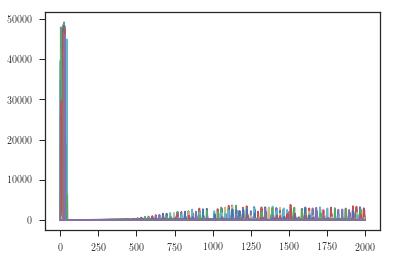

In [44]:
#Normalization stuff.
#It *does* need to happen if you're using the area as the metric. Also, using the maximum in each year starting
#at January doesn't work - because the peak is different at different times. Amalies uses the maximum within a one
#year sliding window, so maybe that's better?

Idata = data_pd.values.copy()
Idata = Idata[:,:]
Idata_norm = np.zeros(shape=np.shape(Idata))
nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
theta = 2.*np.pi*((dates+1)/24.)

print np.max(Idata)
plt.plot(Idata);

In [45]:
def meanNormalize(data):
    fold = 24
    nobs = len(data)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%fold     #A year is 24 timesteps, in this code. For whatever reason.
    nyear = sum(dates==fold-1)
    theta = 2.*np.pi*((dates)/float(fold-1))
    npatch = np.shape(data)[1]  
    thresh = int(npatch/100.)
    thresh = 1.
    data_summed = np.sum(data,axis=1)
    data_summed[data_summed<thresh] = 0.
    data_summed = data_summed/float(npatch)
    data_norm = np.zeros([nobs]) 
    '''
    nhigh = 0
    for i in range(nyear):
        nhigh = np.max(data_summed[i*24:(i+1)*24])
        if nhigh ==0.:
            nhigh = 1.
        data_norm[i*24:(i+1)*24] = data_summed[i*24:(i+1)*24]/float(nhigh)   
    '''
    
    nhigh = 0 
    k = 0
    for d in dates:
        #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
        if k<fold/2:
            nhigh = np.max(data_summed[0:k+fold/2])
        elif k>nobs-fold/2:
            nhigh = np.max(data_summed[k-fold/2:])
        else:
            nhigh = np.max(data_summed[k-fold/2:k+fold/2])    
        if nhigh==0.:
            nhigh += 1.5      #Don't divide by zero.
        data_norm[k] = data_summed[k]/float(nhigh)
        if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
            data_norm[k] = 0.
        k += 1
    
    return data_norm

def Normalize(data):
    nobs = len(data)      #How many 'observations'? (i.e. timesteps)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
    nyear = sum(dates==23)
    theta = 2.*np.pi*((dates)/23.)
    npatch = np.shape(data)[1]  
    data_norm = np.zeros([nobs,npatch])
    #Looks over the calendar year:
    for p in range(npatch):
        nhigh = 0
        for i in range(nyear):
            nhigh = np.max(data[i*24:(i+1)*24,p])
            if nhigh ==0.:
                nhigh = 1.
            data_norm[i*24:(i+1)*24,p] = data[i*24:(i+1)*24,p]/float(nhigh)       
        
    '''
    k = 0
    for d in dates:
        #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
        if k<12:
            nhigh = np.max(data[0:k+12,p])
        elif k>nobs-12:
            nhigh = np.max(data[k-12:,p])
        else:
            nhigh = np.max(data[k-12:k+12,p])    
        if nhigh==0.:
            nhigh += 1.5      #Don't divide by zero.
        data_norm[k,p] = data[k,p]/float(nhigh)
        if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
            data_norm[k,p] = 0.
        k += 1
        '''
    return data_norm

def AreaCalc(data,tstart=800):
    npatch = np.shape(data)[1] 
    area = []
    for i in range(npatch):
        thetafit = theta[tstart:]
        Ifit = data[tstart:,i]
        cartcoords = pol2cart(Ifit,thetafit)
        points = np.array(cartcoords)
        points = points.T
        if len(data)>1:
            hull = ConvexHull(points)
            area.append(hull.volume)
    return area

In [46]:
Idata_norm = meanNormalize(Idata[-5*24:,:])

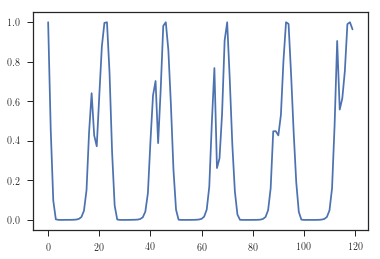

In [47]:
plt.plot(Idata_norm[:]);

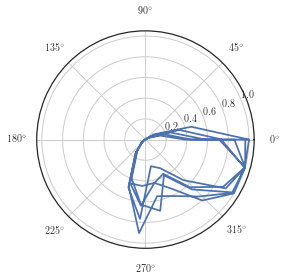

In [48]:
fold = 24
nobs = len(Idata_norm[:])
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%fold     #A year is 24 timesteps, in this code. For whatever reason.
angle = 2.*np.pi*((dates)/float(fold-1))

plt.polar(angle,Idata_norm[:]);


In [21]:
#This will draw a polar plot with the line changing as a function of time, but the output is confusing me.
'''angles = np.repeat(angle,400)
angles = angles.reshape([len(angle),400])
rad = Idata_norm[tstart:]
rad = testdata[0:24]

x = rad * np.sin(angle[0:24])
y = rad * np.cos(angle[0:24])

fig, axes = plt.subplots(figsize=(12,12))

colorline(x, y, cmap='coolwarm', linewidth=2) #, [0.3]*8+[0.4]*4+[0.5]*2)

plt.xlim(x.min() - 0.1, x.max() + 0.1)
plt.ylim(y.min() - 0.1, y.max() + 0.1)

plt.axis('equal')
#clear_frame()
'''

"angles = np.repeat(angle,400)\nangles = angles.reshape([len(angle),400])\nrad = Idata_norm[tstart:]\nrad = testdata[0:24]\n\nx = rad * np.sin(angle[0:24])\ny = rad * np.cos(angle[0:24])\n\nfig, axes = plt.subplots(figsize=(12,12))\n\ncolorline(x, y, cmap='coolwarm', linewidth=2) #, [0.3]*8+[0.4]*4+[0.5]*2)\n\nplt.xlim(x.min() - 0.1, x.max() + 0.1)\nplt.ylim(y.min() - 0.1, y.max() + 0.1)\n\nplt.axis('equal')\n#clear_frame()\n"